# Homogenization

In this example, we demonstrate how to perform computational homogenization using the spectral solver framework. We will define a microstructure, apply macroscopic strains, and compute the effective material properties.

We will make use of the differentiable nature of `xpektra` to compute the tangent stiffness matrix via automatic differentiation using `JAX`.

In [2]:
import jax

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_platforms", "cpu")
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
import time

import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax import Array
from skimage.morphology import disk

We start by importing the necessary libraries and configuring JAX for double-precision computations.

In [3]:
from xpektra import FFTTransform, SpectralOperator, SpectralSpace, make_field
from xpektra.projection_operator import GalerkinProjection
from xpektra.scheme import RotatedDifference
from xpektra.solvers.nonlinear import (  # noqa: E402
    conjugate_gradient,
    newton_krylov_solver,
)

## Define Microstructure

We define a simple microstructure consisting of a circular inclusion in a matrix material.

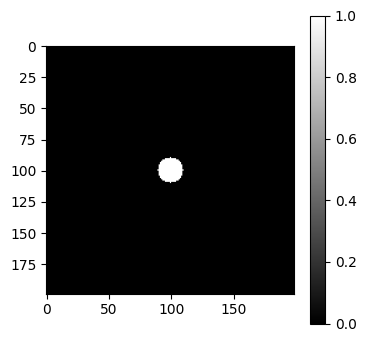

In [4]:
volume_fraction_percentage = 0.007

length = 0.1
H, L = (199, 199)

dx = length / H
dy = length / L

Hmid = int(H / 2)
Lmid = int(L / 2)
vol_inclusion = volume_fraction_percentage * (length * length)
r = (
    int(np.sqrt(vol_inclusion / np.pi) / dx) + 1
)  # Since the rounding off leads to smaller fraction therefore we add 1.

structure = jnp.zeros((H, L))
structure = structure.at[Hmid - r : Hmid + 1 + r, Lmid - r : Lmid + 1 + r].add(disk(r))

ndim = len(structure.shape)

plt.figure(figsize=(4, 4))
plt.imshow(structure, cmap="gray")
plt.colorbar()
plt.show()

## Define Material Properties

We assume the inclusion to be stiffer than the matrix.

In [5]:
# material parameters, lames constant
lambda_matrix = 2.0
mu_matrix = 1.0

lambda_inclusion = 10.0
mu_inclusion = 5.0

lambda_field = lambda_matrix * (1 - structure) + lambda_inclusion * (structure)
mu_field = mu_matrix * (1 - structure) + mu_inclusion * (structure)

## Defining Spectral functions

In [6]:
fft_transform = FFTTransform(dim=ndim)
space = SpectralSpace(
    lengths=(length,) * ndim, shape=structure.shape, transform=fft_transform
)
diff_scheme = RotatedDifference(space=space)

op = SpectralOperator(
    scheme=diff_scheme,
    space=space,
)

In [7]:
dofs_shape = make_field(dim=ndim, shape=structure.shape, rank=2).shape

In [8]:
@eqx.filter_jit
def strain_energy(eps_flat: Array) -> Array:
    eps = eps_flat.reshape(dofs_shape)
    eps_sym = 0.5 * (eps + op.trans(eps))
    energy = 0.5 * jnp.multiply(lambda_field, op.trace(eps_sym) ** 2) + jnp.multiply(
        mu_field, op.trace(op.dot(eps_sym, eps_sym))
    )
    return energy.sum()


compute_stress = jax.jit(jax.jacrev(strain_energy))

In [9]:
Ghat = GalerkinProjection(scheme=diff_scheme)

In [ ]:
@eqx.filter_jit
def residual_fn(eps_flat: Array) -> Array:
    """
    This makes instances of this class behave like a function.
    It takes only the flattened vector of unknowns, as required by the solver.
    """
    eps_flat = eps_flat.reshape(-1)
    sigma = compute_stress(eps_flat)
    residual_field = op.inverse(Ghat.project(op.forward(sigma.reshape(dofs_shape))))
    return jnp.real(residual_field).reshape(-1)

@eqx.filter_jit
def jacobian_fn(deps_flat: Array) -> Array:
    """
    The Jacobian is a linear operator, so its __call__ method
    represents the Jacobian-vector product.
    """

    deps_flat = deps_flat.reshape(-1)
    dsigma = compute_stress(deps_flat)
    jvp_field = op.inverse(Ghat.project(op.forward(dsigma.reshape(dofs_shape))))
    return jnp.real(jvp_field).reshape(-1)

We can define a function to compute the local constitutive response given a macroscopic strain. The function will solve the local problem using a Newton-Krylov solver and return the homogenized stress.

In [12]:
@eqx.filter_jit
def local_constitutive_update(macro_strain):
    # set macroscopic loading
    deps = jnp.array(make_field(dim=2, shape=structure.shape, rank=2))
    deps = deps.at[:, :, 0, 0].set(macro_strain[0])
    deps = deps.at[:, :, 1, 1].set(macro_strain[1])
    deps = deps.at[:, :, 0, 1].set(macro_strain[2] / 2.0)
    deps = deps.at[:, :, 1, 0].set(macro_strain[2] / 2.0)

    # initial residual: distribute "deps" over grid
    b = -residual_fn(deps)

    eps = newton_krylov_solver(
        x=deps.reshape(-1),
        b=b,
        gradient=residual_fn,
        jacobian=jacobian_fn,
        tol=1e-8,
        max_iter=20,
        krylov_solver=conjugate_gradient,
        krylov_tol=1e-8,
        krylov_max_iter=20,
    )

    sig = compute_stress(eps).reshape(dofs_shape)

    # get the macro stress
    macro_sigma = jnp.array(
        [
            jnp.sum(sig.at[:, :, 0, 0].get() * dx * dy),
            jnp.sum(sig.at[:, :, 1, 1].get() * dx * dy),
            0.5
            * (
                jnp.sum(sig.at[:, :, 1, 0].get() * dx * dy)
                + jnp.sum(sig.at[:, :, 0, 1].get() * dx * dy)
            ),
        ]
    )
    macro_sigma = macro_sigma / length**2

    return macro_sigma, (macro_sigma, sig, eps)

We use the `jax.jacfwd` to differentiate the stress computation function to obtain the tangent operator.

$$
\mathbb{C} = \frac{\partial \sigma(\varepsilon_\text{macro})}{\partial \varepsilon_\text{macro}}
$$

In [13]:
tangent_operator_and_state = jax.jacfwd(
    local_constitutive_update, argnums=0, has_aux=True
)

In [14]:
deps = jnp.array([1.2, 1.0, 1])

start_time = time.time()
tangent, state = tangent_operator_and_state(deps)
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

CG error = 224400.41364612031612
CG error = 50313.99409105765517
CG error = 50313.99409105771338
CG error = 5031.39940910609221
CG error = 0.00000007431096
CG error = 0.00000006452637
CG error = 0.00000006452637
CG error = 0.00000000553261
Converged, Residual value : 6.81952085987499e-09
Time taken: 4.757754325866699 seconds


The homogenized tangent stiffness matrix is thus computed as:


In [15]:
print(tangent)

[[ 4.03381561e+00  2.01484013e+00 -3.33717746e-18]
 [ 2.01484013e+00  4.03381561e+00 -4.23053252e-18]
 [-1.63649412e-18  2.77932686e-19  1.00910293e+00]]
